# Modeling
- Logistic Regression, Random forest and XGBoost were built to do the prediction
- We use the models to predict if a horse is the top 3 winner
- For each model, we preform Gridsearch, and optimization
- At last, we choose the model with the best ROC and then proceed to SHAP explaination

In [1]:
# This code imports some libraries that you will need.
# Python ≥3.5 is required

import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np


# Pandas for overview
import pandas as pd


# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#models
from sklearn.svm import SVC
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.stats import randint as sp_randint
from sklearn.ensemble import BaggingClassifier,VotingClassifier, AdaBoostClassifier, StackingClassifier, RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
# from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
#import matplotlib as plt

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [2]:
# load the preprocessed data
df_runs_processed = pd.read_csv("all_runs_processed.csv")
df_runs_processed.head(2)


race_id  horse_no  horse_id  result  won  lengths_behind  horse_age  \
0        0         1      3917      10  0.0            8.00          3   
1        0         2      2157       8  0.0            5.75          3   

  horse_country  horse_type  horse_rating  ...  \
0           AUS           3            60  ...   
1            NZ           3            60  ...   

                          all_runs_finished_position  most_frequent_finish  \
0  [12, 7, 8, 9, 6, 11, 11, 12, 12, 12, 8, 12, 10...                    12   
1  [8, 9, 11, 12, 9, 10, 2, 9, 10, 12, 8, 10, 10,...                    10   

   top_3_most_frequent_finish  best_3_values  top_3_prob  average_rank  \
0                      12,8,7      [1, 2, 3]      0.2000      7.566667   
1                      10,8,9      [1, 2, 3]      0.1875      7.937500   

   is_top_3  Top3Finishes  jockey_total_races  jockey_placement_perc  
0         0          1811                4719              38.376775  
1         0           509                1893              26.888537  

[2 rows x 57 columns]

In [3]:
print(df_runs_processed.shape)
print(df_runs_processed.columns)

(79447, 57)
Index(['race_id', 'horse_no', 'horse_id', 'result', 'won', 'lengths_behind',
       'horse_age', 'horse_country', 'horse_type', 'horse_rating',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw',
       'position_sec1', 'position_sec2', 'position_sec3', 'position_sec4',
       'position_sec5', 'position_sec6', 'behind_sec1', 'behind_sec2',
       'behind_sec3', 'behind_sec4', 'behind_sec5', 'behind_sec6', 'time1',
       'time2', 'time3', 'time4', 'time5', 'time6', 'finish_time', 'win_odds',
       'place_odds', 'jockey_id', 'venue', 'config', 'surface', 'distance',
       'going', 'horse_ratings', 'prize', 'race_class', 'horse_place_perc',
       'jockey_place_perc', 'trainer_place_perc', 'all_runs_finished_position',
       'most_frequent_finish', 'top_3_most_frequent_finish', 'best_3_values',
       'top_3_prob', 'average_rank', 'is_top_3', 'Top3Finishes',
       'jockey_total_races', 'jockey_placement_perc'],
      dtype='object')


# Create train test data

In [4]:
# method one
import pandas as pd
from sklearn.model_selection import train_test_split

# select the features and possible targets for classification modeling
df_selected_modeling = df_runs_processed[['race_id', 'horse_no', 'horse_id','won','is_top_3', 'horse_age',
        'horse_type', 'horse_gear',
       'declared_weight', 'actual_weight', 'draw', 'win_odds',
       'place_odds', 'venue', 'config', 'surface', 'distance', 'going',
       'race_class', 'horse_place_perc', 'jockey_place_perc',
       'trainer_place_perc', 'average_rank','jockey_placement_perc','Top3Finishes']] # Replace with your actual feature columns

#y_1 = df_runs_processed['won']  # Replace with your actual target column
#y_2= df_runs_processed['top_3_prob']
#y_3= df_runs_processed['result']

# split the data into training ,validation ,testing 7:3
train_set, bigtest_set = train_test_split(df_selected_modeling, test_size = 0.2, random_state=42)
val_set,test_set = train_test_split(bigtest_set, test_size=0.5, random_state=42)


In [5]:
# training
X_train = train_set.drop(['won','is_top_3'],axis=1)
y_train = train_set['is_top_3']

# validation
X_val = val_set.drop(['won','is_top_3'],axis=1)
y_val = val_set['is_top_3']

# test
X_test = test_set.drop(['won','is_top_3'],axis=1)
y_test = test_set['is_top_3']


#Verify the size and label distribution in each dataset.

print("Training dataset size:",y_train.shape[0])
print("Training dataset distribution:\n", y_train.value_counts())

print("Validation dataset size:",y_val.shape[0])
print("Validation dataset distribution:\n", y_val.value_counts())

print("Test dataset size: ",y_test.shape[0])
print("Test dataset distribution:\n ", y_test.value_counts())

Training dataset size: 63557
Training dataset distribution:
 is_top_3
0    48261
1    15296
Name: count, dtype: int64
Validation dataset size: 7945
Validation dataset distribution:
 is_top_3
0    6027
1    1918
Name: count, dtype: int64
Test dataset size:  7945
Test dataset distribution:
  is_top_3
0    6092
1    1853
Name: count, dtype: int64


## Logistic Regression

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


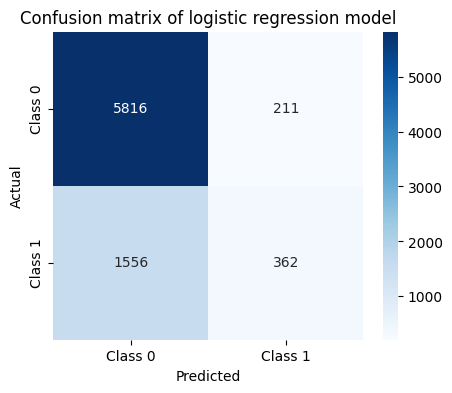

In [6]:
logistic_regression_model = LogisticRegression(max_iter=50)

# Define a hyperparameter grid to search
lrm_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'lbfgs']
}

# Perform grid search with cross-validation to find the best hyperparameters
lrm_grid_search = GridSearchCV(logistic_regression_model, lrm_param_grid, cv=5)
lrm_grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
lrm_best_params = lrm_grid_search.best_params_
print("Best Hyperparameters:", lrm_best_params)

# Use the best model from the grid search
best_logistic_regression_model = lrm_grid_search.best_estimator_

# Perform cross-validation and get predicted labels
lrm_y_pred_cv = cross_val_predict(best_logistic_regression_model, X_train, y_train, cv=5)

# Fit the model on the training data
best_logistic_regression_model.fit(X_train, y_train)

# Get predicted labels on the test data
lrm_y_pred = best_logistic_regression_model.predict(X_val)


lrm_conf_matrix = confusion_matrix(y_val, lrm_y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(lrm_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of logistic regression model')
plt.show()


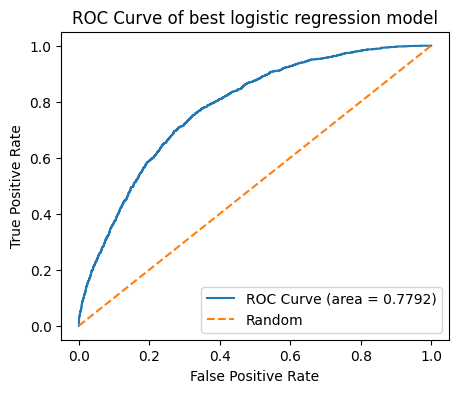

ROC-AUC Score: 0.7791925386854046
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.96      0.87      6027
           1       0.63      0.19      0.29      1918

    accuracy                           0.78      7945
   macro avg       0.71      0.58      0.58      7945
weighted avg       0.75      0.78      0.73      7945



In [7]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
# Calculate and plot ROC curve
lrm_roc_auc = roc_auc_score(y_val, best_logistic_regression_model.predict_proba(X_val)[:, 1])

lrm_fpr, lrm_tpr, lrm_thresholds = roc_curve(y_val, best_logistic_regression_model.predict_proba(X_val)[:, 1])
plt.figure(figsize=(5, 4))
plt.plot(lrm_fpr, lrm_tpr, label=f'ROC Curve (area = {lrm_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of best logistic regression model')
plt.legend()
plt.show()

# Calculate ROC-AUC score
lrm_roc_auc = roc_auc_score(y_val, best_logistic_regression_model.predict_proba(X_val)[:, 1])
print("ROC-AUC Score:", lrm_roc_auc)

# Generate and print classification report
lrm_classification_rep = classification_report(y_val, lrm_y_pred)
print("Classification Report:\n", lrm_classification_rep)

In [8]:
# Calculate precision
lrm_precision = metrics.precision_score(y_val, lrm_y_pred)

# Calculate recall
lrm_recall = metrics.recall_score(y_val, lrm_y_pred)

# Calculate ROC AUC
lrm_roc_auc = roc_auc_score(y_val, best_logistic_regression_model.predict_proba(X_val)[:, 1])

print(f'Precision: {lrm_precision}')
print(f'Recall: {lrm_recall}')
print(f'ROC AUC: {lrm_roc_auc}')

Precision: 0.631762652705061
Recall: 0.18873826903023982
ROC AUC: 0.7791925386854046


# Random Forest Classifer

Best Hyperparameters: {'max_depth': 10, 'n_estimators': 50}


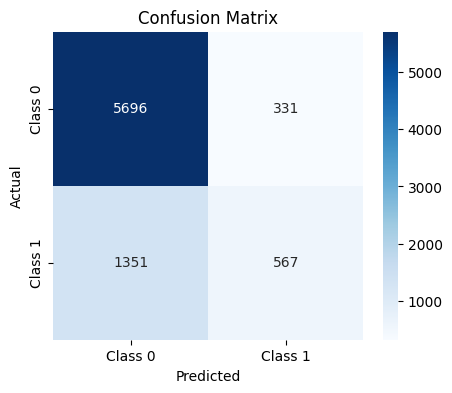

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve

# Define the hyperparameter grid to search
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}

# Perform grid search with cross-validation to find the best hyperparameters
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
rf_best_params = rf_grid_search.best_params_
print("Best Hyperparameters:", rf_best_params)

# Use the best model from the grid search
best_random_forest_model = rf_grid_search.best_estimator_

# Perform cross-validation and get predicted labels
rf_y_pred_cv = cross_val_predict(best_random_forest_model, X_train, y_train, cv=5)

# Get predicted labels on the test data
rf_y_pred = best_random_forest_model.predict(X_val)

# Plot confusion matrix for the test set
rf_conf_matrix = confusion_matrix(y_val, rf_y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

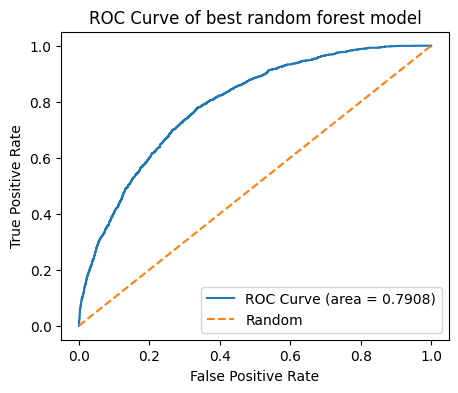

ROC-AUC Score: 0.7908328060744376
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.87      6027
           1       0.63      0.30      0.40      1918

    accuracy                           0.79      7945
   macro avg       0.72      0.62      0.64      7945
weighted avg       0.77      0.79      0.76      7945



In [10]:
# Calculate and plot ROC curve
rf_roc_auc = roc_auc_score(y_val, best_random_forest_model.predict_proba(X_val)[:, 1])

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val, best_random_forest_model.predict_proba(X_val)[:, 1])
plt.figure(figsize=(5, 4))
plt.plot(rf_fpr, rf_tpr, label=f'ROC Curve (area = {rf_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of best random forest model')
plt.legend()
plt.show()

# Calculate ROC-AUC score
rf_roc_auc = roc_auc_score(y_val, best_random_forest_model.predict_proba(X_val)[:, 1])
print("ROC-AUC Score:", rf_roc_auc)

# Generate and print classification report
rf_classification_rep = classification_report(y_val, rf_y_pred)
print("Classification Report:\n", rf_classification_rep)

In [11]:
rf_precision = metrics.precision_score(y_val, rf_y_pred)
rf_recall = metrics.recall_score(y_val, rf_y_pred)
rf_roc_auc = metrics.roc_auc_score(y_val, best_random_forest_model.predict_proba(X_val)[:, 1])

print(f'rf_Precision: {rf_precision}')
print(f'rf_Recall: {rf_recall}')
print(f'rf_ROC AUC: {rf_roc_auc}')


rf_Precision: 0.6314031180400891
rf_Recall: 0.2956204379562044
rf_ROC AUC: 0.7908328060744376


## XGBoost

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


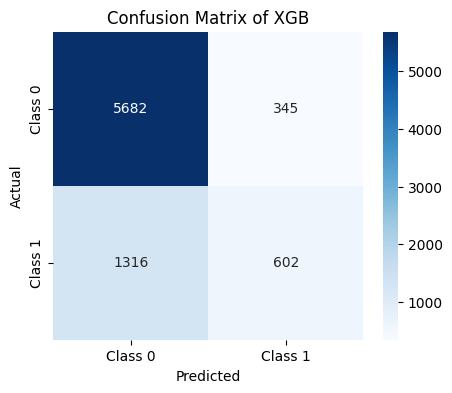

In [12]:
from xgboost import XGBClassifier

# Create an XGBoost model
xgb_model = XGBClassifier()

# Define hyperparameters to tune
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform Grid Search with Cross-Validation
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
xgb_best_params = xgb_grid_search.best_params_
print("Best Hyperparameters:", xgb_best_params)
best_xgb_model = xgb_grid_search.best_estimator_

# Perform cross-validation and get predicted labels
#xgb_y_pred_cv = cross_val_predict(best_random_forest_model, X_train, y_train, cv=5)

# Get predicted labels on the test data
xgb_y_pred = best_xgb_model.predict(X_val)

# Plot confusion matrix for the test set
xgb_conf_matrix = confusion_matrix(y_val, xgb_y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of XGB')
plt.show()

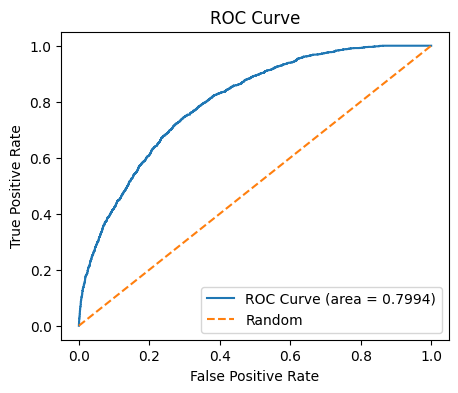

ROC-AUC Score: 0.7993623324860858
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      6027
           1       0.64      0.31      0.42      1918

    accuracy                           0.79      7945
   macro avg       0.72      0.63      0.65      7945
weighted avg       0.77      0.79      0.76      7945



In [13]:
# Calculate and plot ROC curve
xgb_roc_auc = roc_auc_score(y_val, best_xgb_model.predict_proba(X_val)[:, 1])

xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_val, best_xgb_model.predict_proba(X_val)[:, 1])
plt.figure(figsize=(5, 4))
plt.plot(xgb_fpr, xgb_tpr, label=f'ROC Curve (area = {xgb_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate ROC-AUC sco
print("ROC-AUC Score:", xgb_roc_auc)

# Generate and print classification report
xgb_classification_rep = classification_report(y_val, xgb_y_pred)
print("Classification Report:\n", xgb_classification_rep)

In [14]:
xgb_precision = metrics.precision_score(y_val, xgb_y_pred)
xgb_recall = metrics.recall_score(y_val, xgb_y_pred)
xgb_roc_auc = metrics.roc_auc_score(y_val, best_xgb_model.predict_proba(X_val)[:, 1])

print(f'rf_Precision: {xgb_precision}')
print(f'rf_Recall: {xgb_recall}')
print(f'rf_ROC AUC: {xgb_roc_auc}')

rf_Precision: 0.6356916578669483
rf_Recall: 0.31386861313868614
rf_ROC AUC: 0.7993623324860858


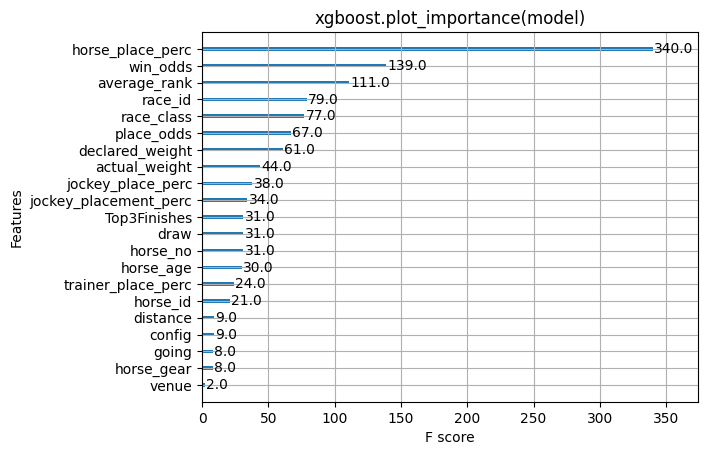

In [15]:
import xgboost
xgboost.plot_importance(best_xgb_model)
plt.title("xgboost.plot_importance(model)")
plt.show()

Accuracy: 0.7942101950912523


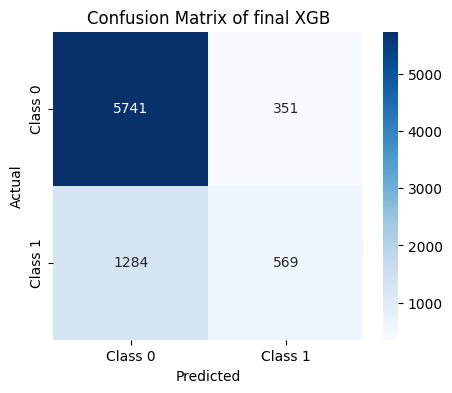

In [16]:
from sklearn.metrics import accuracy_score
# final accuracy with best model
final_y_pred = best_xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, final_y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix for the test set
final_xgb_conf_matrix = confusion_matrix(y_test, final_y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(final_xgb_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of final XGB')
plt.show()


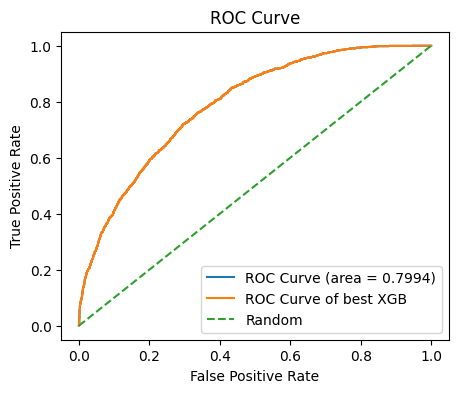

ROC-AUC Score: 0.7898189268418517
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      6092
           1       0.62      0.31      0.41      1853

    accuracy                           0.79      7945
   macro avg       0.72      0.62      0.64      7945
weighted avg       0.77      0.79      0.77      7945



In [17]:
# Calculate and plot ROC curve
final_xgb_roc_auc = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

final_xgb_fpr, final_xgb_tpr, final_xgb_thresholds = roc_curve(y_test, best_xgb_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(5, 4))
plt.plot(final_xgb_fpr, final_xgb_tpr, label=f'ROC Curve (area = {xgb_roc_auc:.4f})')
plt.plot(final_xgb_fpr, final_xgb_tpr, label='ROC Curve of best XGB')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate ROC-AUC sco
print("ROC-AUC Score:", final_xgb_roc_auc)

# Generate and print classification report
final_xgb_classification_rep = classification_report(y_test, final_y_pred)
print("Classification Report:\n", final_xgb_classification_rep)

In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_train and y_pred_train are your true labels and predicted labels on the training set
conf_matrix_train = confusion_matrix(y_test, final_y_pred)

# Extract FP and FN indices on the training set
fp_indices_train = np.where((y_test == 0) & (final_y_pred == 1))[0]
fn_indices_train = np.where((y_test == 1) & (final_y_pred == 0))[0]

# Concatenate FP and FN indices to get all misclassified indices
misclassified_indices_train = np.concatenate([fp_indices_train, fn_indices_train])

# Create a DataFrame for misclassified instances on the training set
misclassified_df_train = pd.concat([X_train.iloc[misclassified_indices_train, :], y_train.iloc[misclassified_indices_train]], axis=1)
misclassified_df_train.shape

X_misclassified = misclassified_df_train.drop(['is_top_3'],axis=1)
y_misclassified = misclassified_df_train['is_top_3']



PermutationExplainer explainer: 1636it [00:49, 26.61it/s]                          


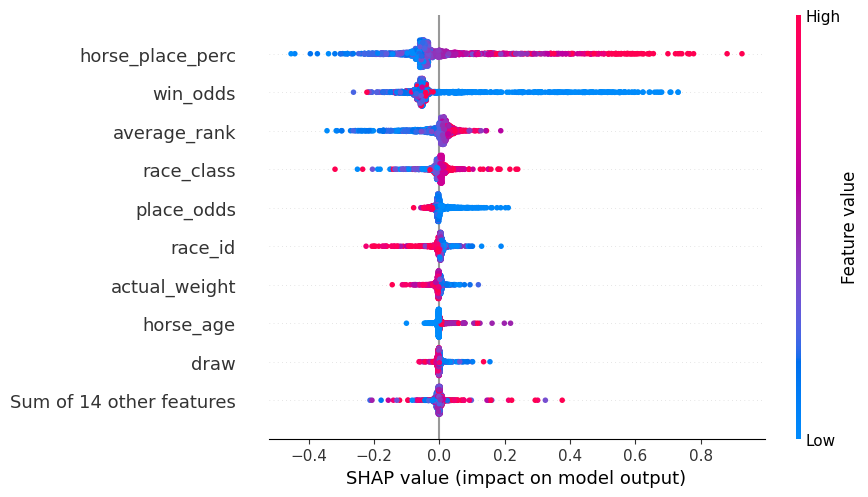

In [19]:
# plot the shap with misclassified observation
import shap
explainer_xgb_misclassified = shap.Explainer(best_xgb_model.predict, X_misclassified)
shap_values_xgb_misclassified  = explainer_xgb_misclassified(X_misclassified)
shap.plots.beeswarm(shap_values_xgb_misclassified)

In [20]:
import pandas as pd

# Assuming X_test is your test features DataFrame and y_test is the corresponding labels Series

# Pick a single instance from the test set (for example, the first instance)
single_instance_index = 0
single_instance_features = X_test.iloc[single_instance_index, :]
true_label = y_test.iloc[single_instance_index]

# Display the selected single instance
print("Selected Single Instance Features:")
print(single_instance_features)
print("True Label for the Single Instance:", true_label)

# Assuming best_model is your pre-trained model

# Make predictions on the single test instance
single_instance_pred = best_xgb_model.predict(single_instance_features.values.reshape(1, -1))

# Display the predicted label
print("Predicted Label for the Single Instance:", single_instance_pred[0])

# Evaluate the prediction
accuracy = 1 if single_instance_pred[0] == true_label else 0
print("Accuracy:", accuracy)


Selected Single Instance Features:
race_id                  3232.000000
horse_no                    6.000000
horse_id                  445.000000
horse_age                   3.000000
horse_type                  3.000000
horse_gear                  0.000000
declared_weight          1271.000000
actual_weight             126.000000
draw                        4.000000
win_odds                   60.000000
place_odds                 13.000000
venue                       1.000000
config                      0.000000
surface                     0.000000
distance                 1200.000000
going                       1.000000
race_class                 11.000000
horse_place_perc            0.060086
jockey_place_perc           0.037804
trainer_place_perc          0.058477
average_rank                5.547619
jockey_placement_perc      24.868651
Top3Finishes              852.000000
Name: 40445, dtype: float64
True Label for the Single Instance: 0
Predicted Label for the Single Instance: 0
Accur

## SHAP explaination with the best model
-best_xgb_model is the best model

In [65]:
# SHAP values
import shap

# fit the model
#best_xgb_model.fit(X_train, y_train)
explainer_xgb = shap.Explainer(best_xgb_model.predict, X_train)
shap_values_xgb = explainer_xgb(X_train)

PermutationExplainer explainer: 63558it [46:11, 22.81it/s]                              


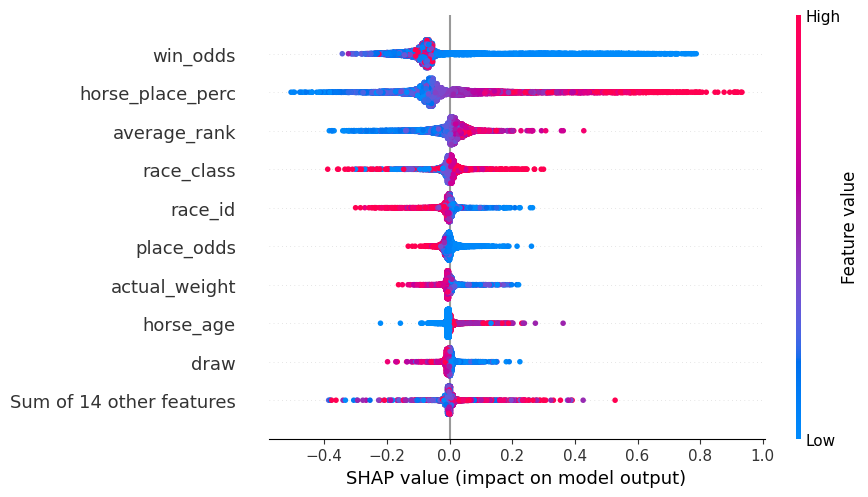

In [22]:
shap.plots.beeswarm(shap_values_xgb)

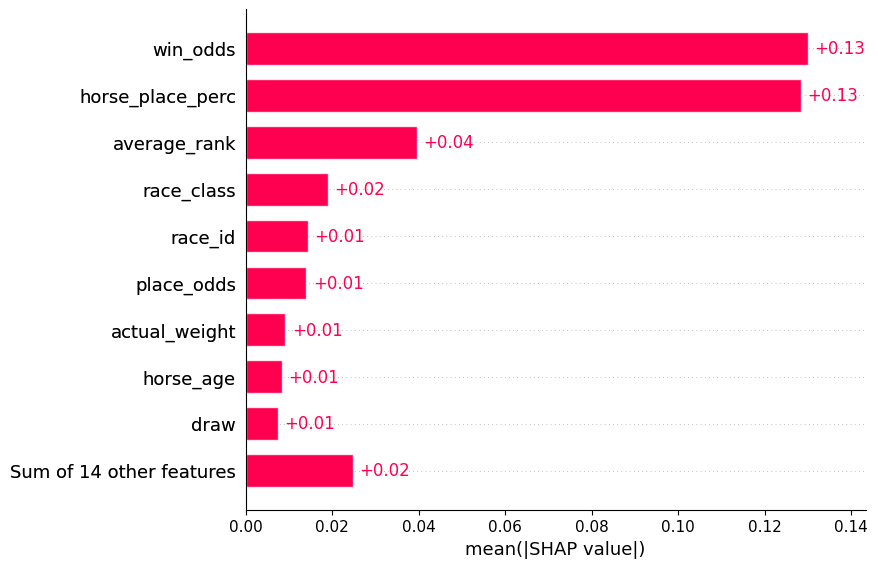

In [23]:
shap.plots.bar(shap_values_xgb)

In [24]:
# Extract the feature names
names = X_train.columns[0:]
print(names)

Index(['race_id', 'horse_no', 'horse_id', 'horse_age', 'horse_type',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw', 'win_odds',
       'place_odds', 'venue', 'config', 'surface', 'distance', 'going',
       'race_class', 'horse_place_perc', 'jockey_place_perc',
       'trainer_place_perc', 'average_rank', 'jockey_placement_perc',
       'Top3Finishes'],
      dtype='object')


## Tree Shap
We use tree SHAP for experiment because XGBoost is a tree base model

In [25]:
# Build a tree SHAP explainer for the XGBoost model and calculate the SHAP value
xgb_tree_explainer = shap.TreeExplainer(best_xgb_model)
xgb_tree_shap_values = xgb_tree_explainer.shap_values(X_train)

In [45]:
# Find a lucky horse and loser horse as examplese for SHAP local interpretaitlty 
df = train_set.copy()
# Find the observation with the largest value in 'Top3Finishes' and, in case of ties, the largest value in 'win_odd'
max_top3_finishes_observation = df.sort_values(by=['Top3Finishes', 'win_odds'], ascending=[False, True]).iloc[0]
# Display the result as a DataFrame
result_lucky_horse_df = pd.DataFrame([max_top3_finishes_observation], columns=df.columns)
result_lucky_horse_df

race_id  horse_no  horse_id  won  is_top_3  horse_age  horse_type  \
27223   2179.0       3.0    2521.0  1.0       1.0        3.0         3.0   

       horse_gear  declared_weight  actual_weight  ...  surface  distance  \
27223         0.0           1177.0          120.0  ...      0.0    1400.0   

       going  race_class  horse_place_perc  jockey_place_perc  \
27223    1.0         6.0          0.054237           0.073136   

       trainer_place_perc  average_rank  jockey_placement_perc  Top3Finishes  
27223            0.040311           5.9              38.376775        1811.0  

[1 rows x 25 columns]

In [51]:
# Find loser horse as examplese for SHAP local interpretaitlty 
# Find the observation with the low value in 'Top3Finishes' and high value in 'win_odd'
max_top3_finishes_observation = df.sort_values(by=['Top3Finishes', 'win_odds'], ascending=[True, False]).iloc[0]
# Display the result as a DataFrame
result_loser_horse_df = pd.DataFrame([max_top3_finishes_observation], columns=df.columns)
result_loser_horse_df

race_id  horse_no  horse_id  won  is_top_3  horse_age  horse_type  \
33883   2705.0      11.0    2148.0  0.0       0.0        3.0         3.0   

       horse_gear  declared_weight  actual_weight  ...  surface  distance  \
33883         0.0           1117.0          120.0  ...      0.0    1400.0   

       going  race_class  horse_place_perc  jockey_place_perc  \
33883    1.0        13.0               0.0                0.0   

       trainer_place_perc  average_rank  jockey_placement_perc  Top3Finishes  
33883                 0.0      8.666667                    0.0           0.0  

[1 rows x 25 columns]

In [59]:
# find the row number of the winner and loser, so as the find the respective place of SHAP values
row_number_winner = df.index.get_loc(27223)
row_number_loser = df.index.get_loc(59732)
print("row_number_winner:",row_number_winner,"\nrow_number_loser:",row_number_loser)

row_number_winner: 15691 
row_number_loser: 2233


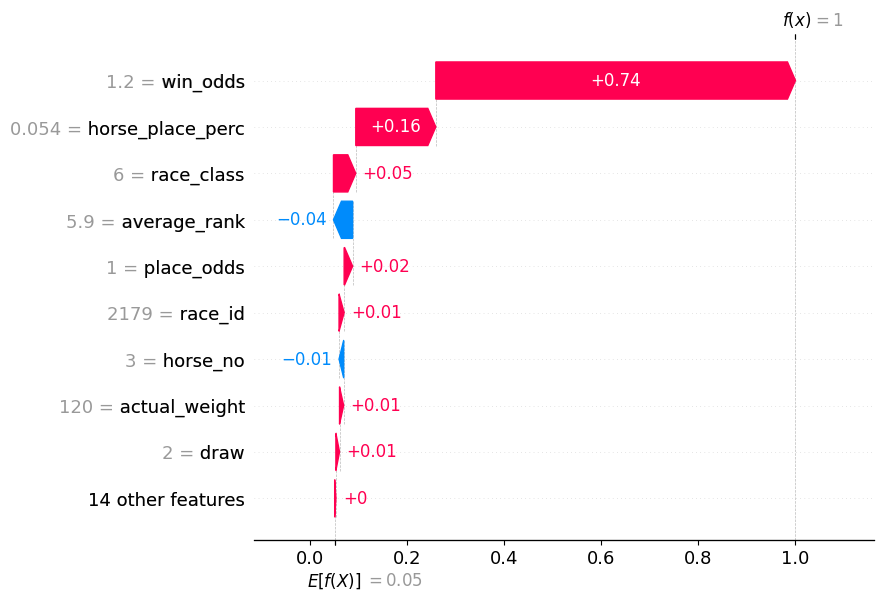

In [67]:
shap.plots.waterfall(shap_values_xgb[15691])

In [49]:
shap.initjs()
# plot a particualar case for horse with high Top3Finishes and low win odds
shap.force_plot(xgb_tree_explainer.expected_value, xgb_tree_shap_values[15691, :], X_train.iloc[15691, :])

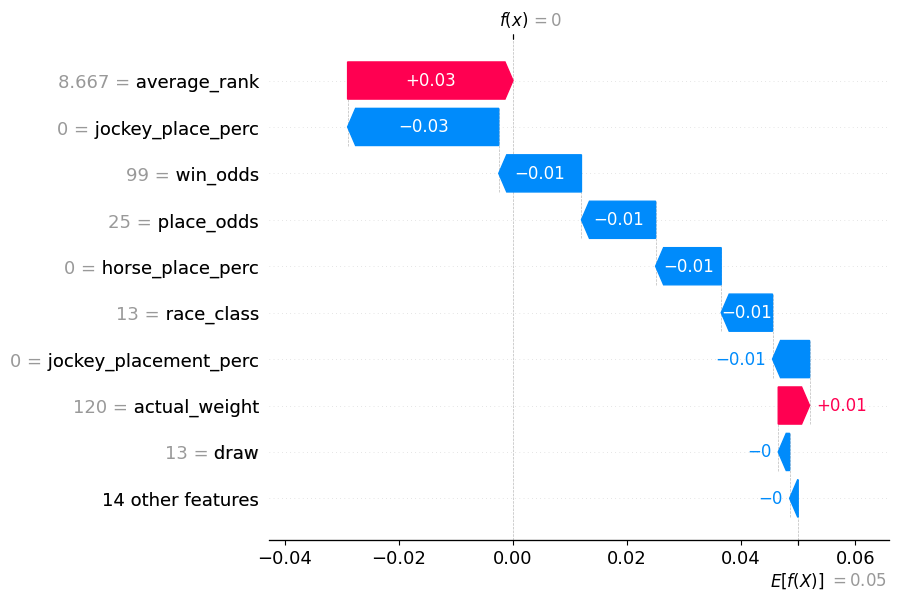

In [68]:
shap.plots.waterfall(shap_values_xgb[560])

In [61]:
shap.initjs()
# plot a particualar case for horse with low Top3Finishes and high win odds
shap.force_plot(xgb_tree_explainer.expected_value, xgb_tree_shap_values[560, :], X_train.iloc[560, :])

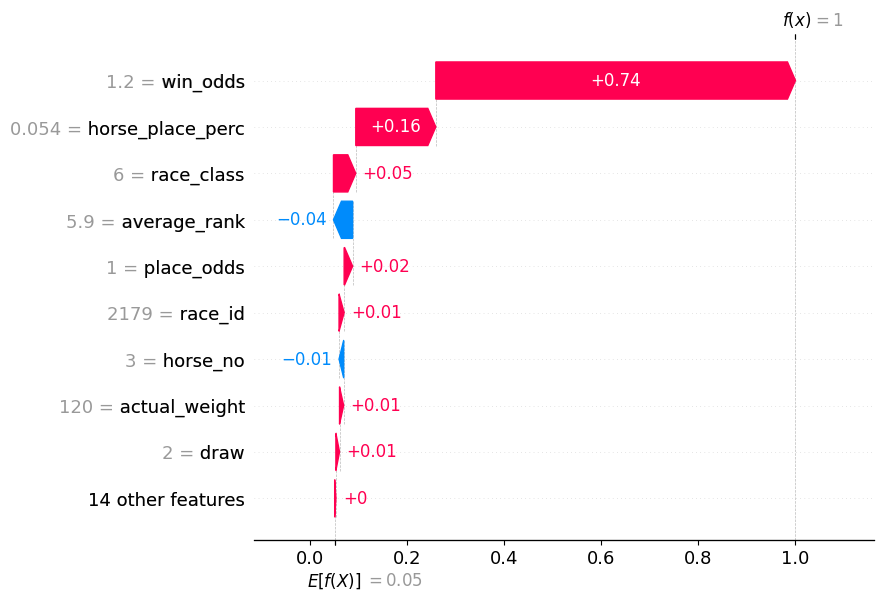

In [36]:
shap.force_plot(
    xgb_tree_explainer.expected_value, xgb_tree_shap_values[:1000, :], X_train.iloc[:1000, :]
)


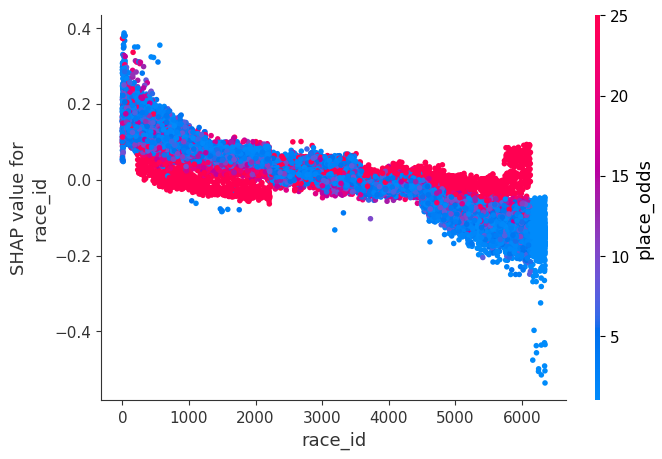

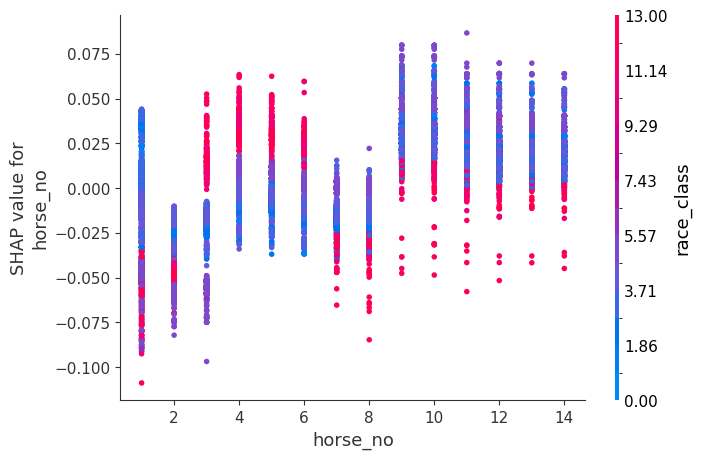

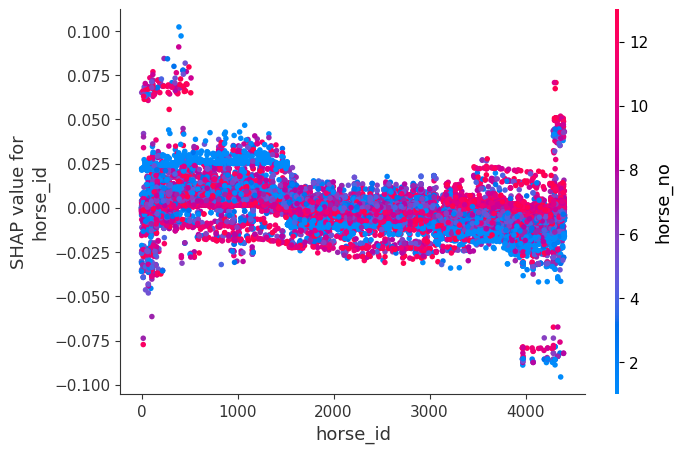

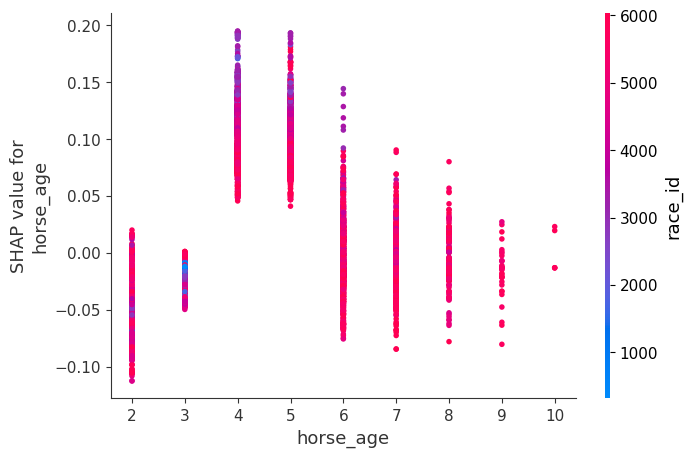

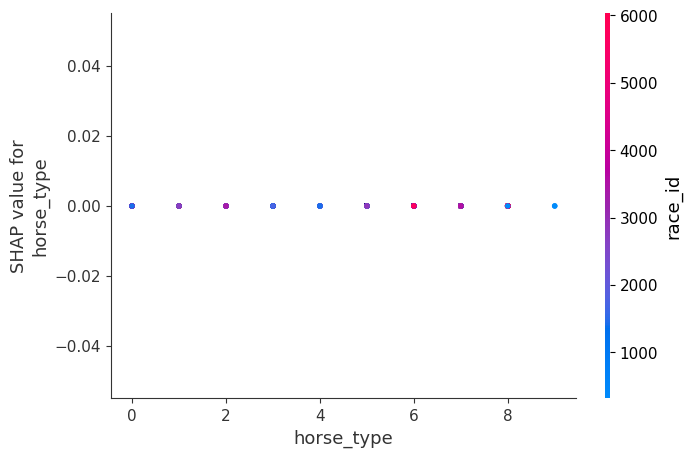

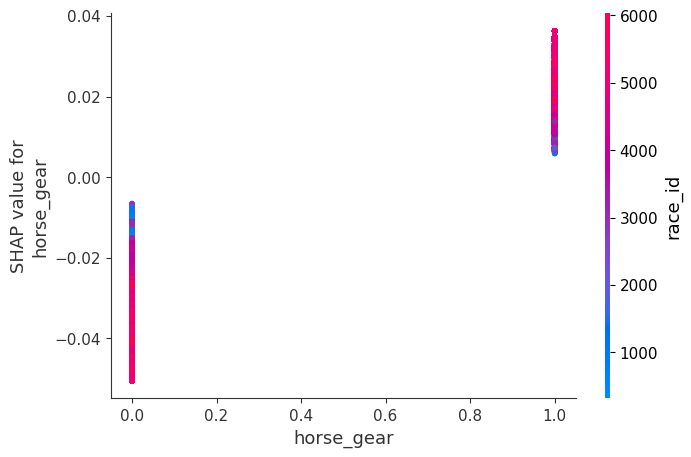

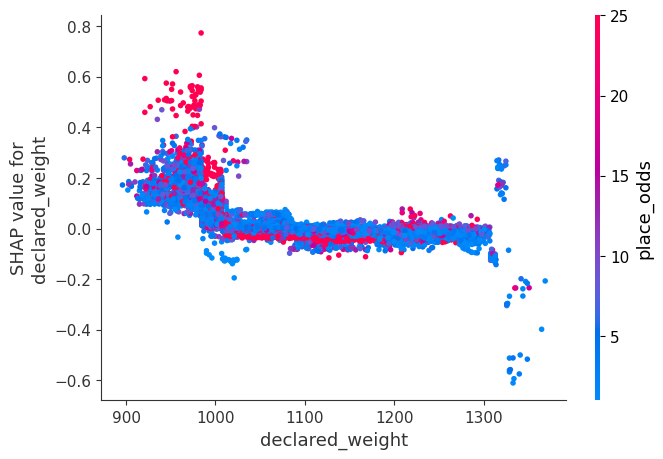

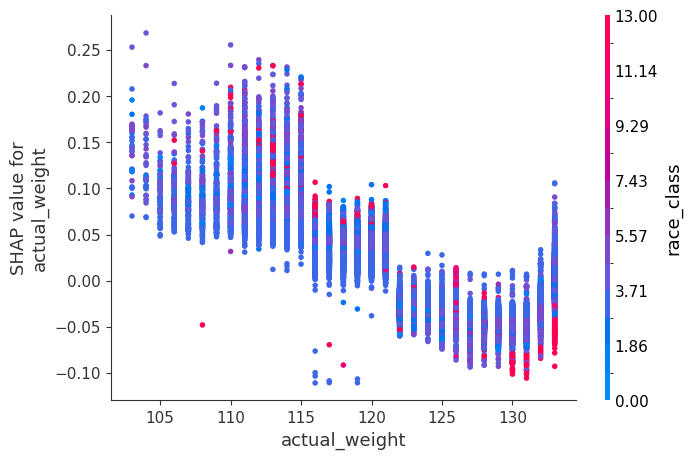

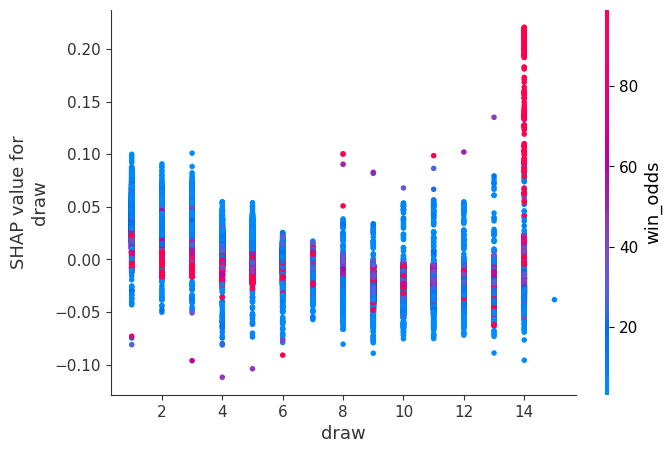

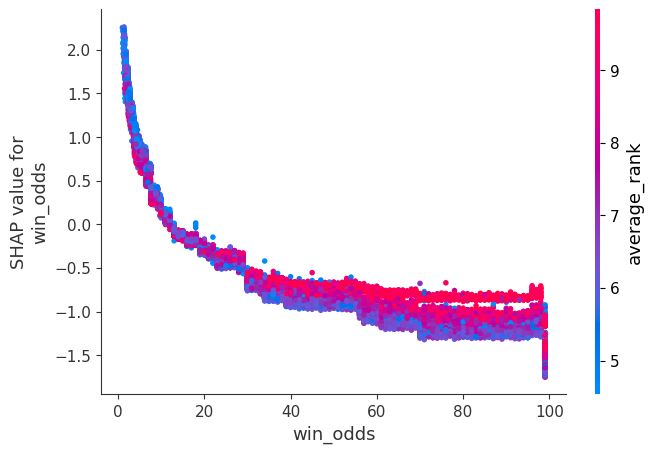

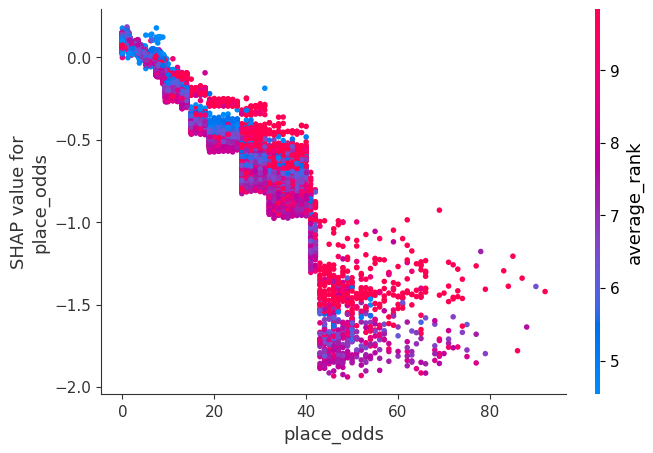

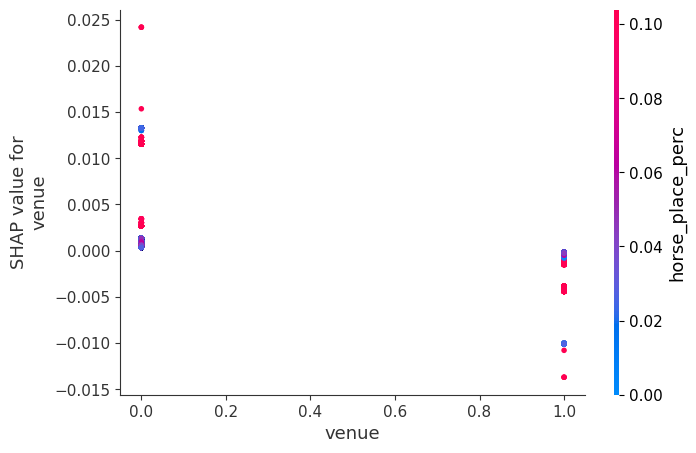

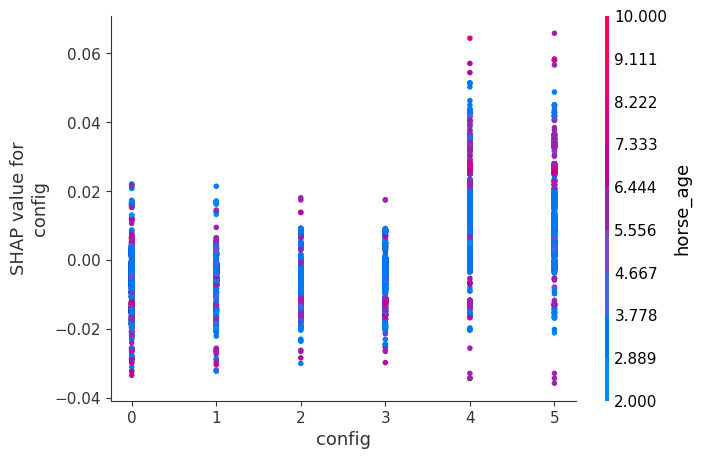

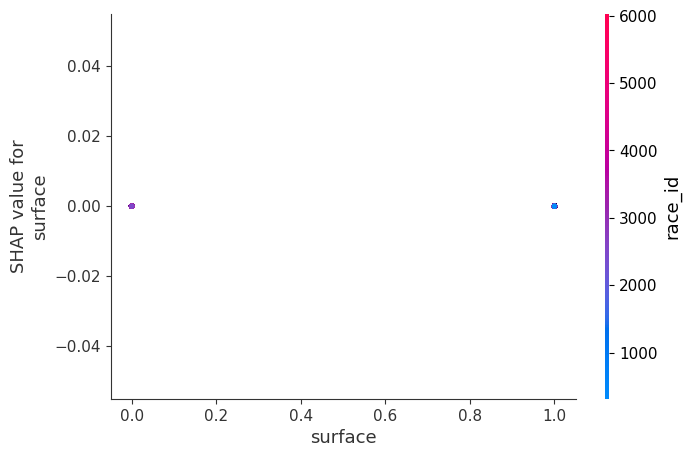

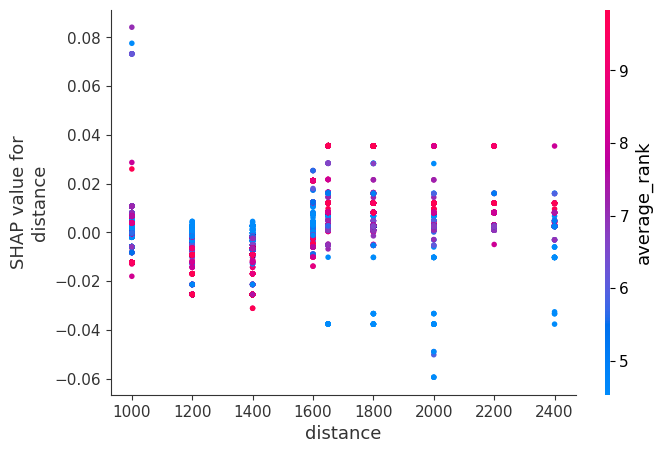

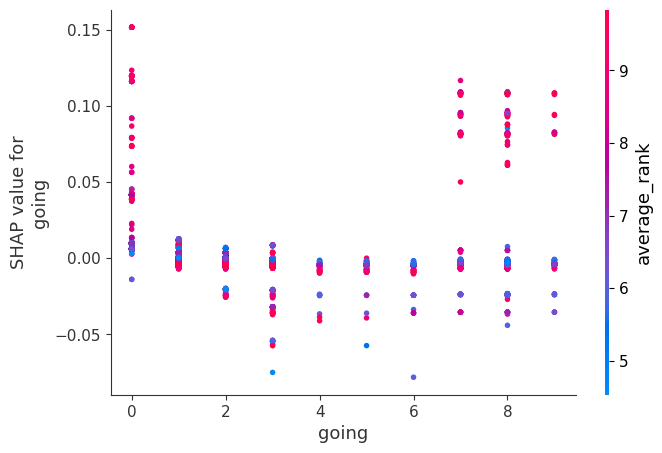

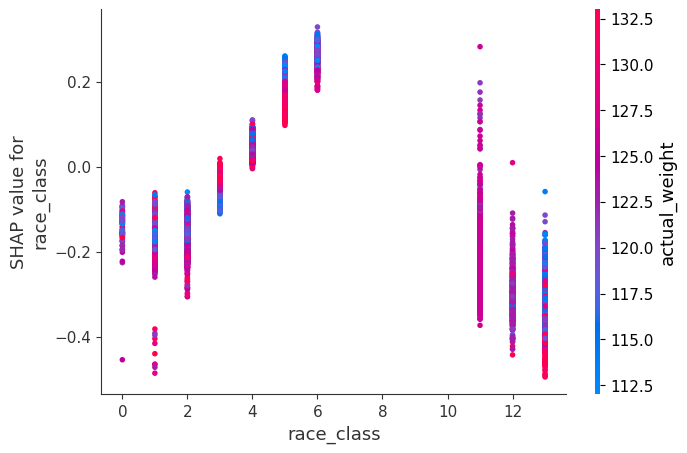

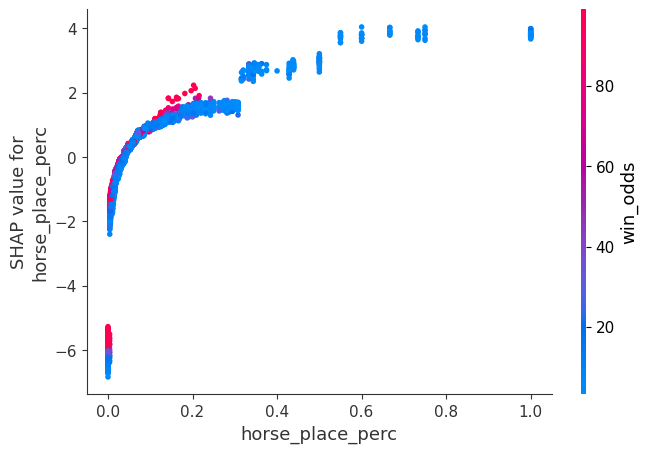

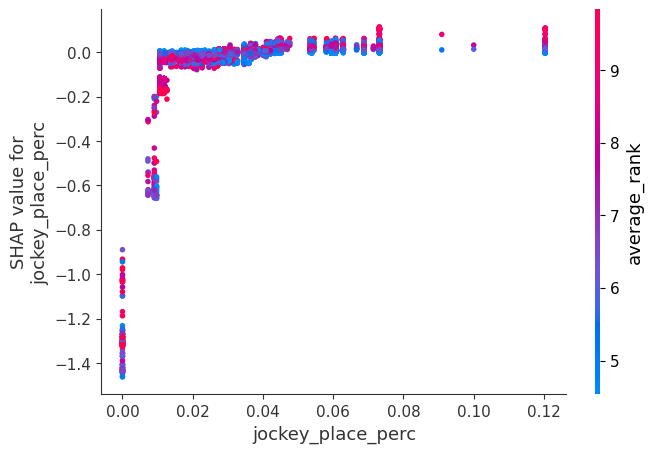

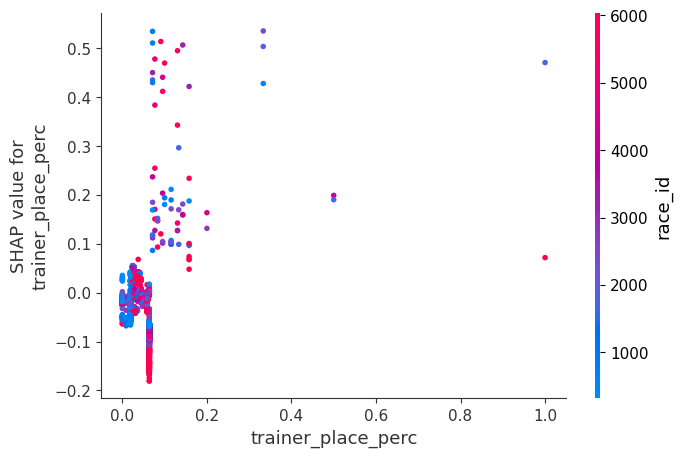

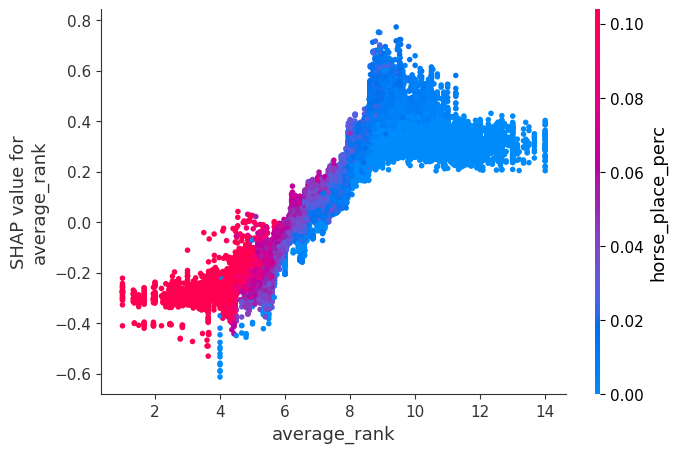

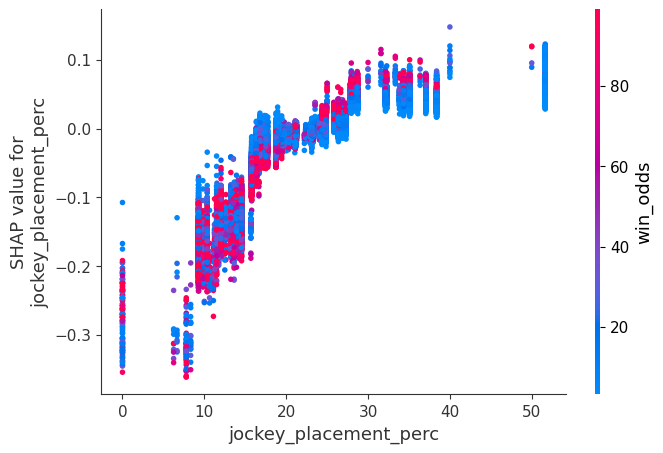

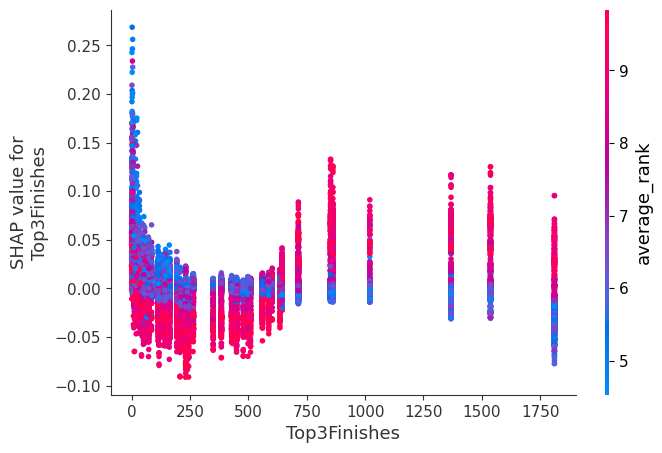

In [37]:
for name in X_train.columns:
    shap.dependence_plot(name, xgb_tree_shap_values, X_train, display_features=X_train)